In [1]:
%matplotlib inline
import os

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

from torchsummary import summary

device = torch.device('cuda:1')

In [2]:
# fileid: 12XWUcct4LA_bZXaccScYUBC97S9R90L1
# filename: crop_part1.tar.gz
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=12XWUcct4LA_bZXaccScYUBC97S9R90L1' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=12XWUcct4LA_bZXaccScYUBC97S9R90L1" -O crop_part1.tar.gz && rm -rf ~/cookies.txt
!tar -zxvf crop_part1.tar.gz

--2022-02-20 19:46:03--  https://docs.google.com/uc?export=download&confirm=t&id=12XWUcct4LA_bZXaccScYUBC97S9R90L1
Resolving docs.google.com (docs.google.com)... 142.250.196.142, 2404:6800:4004:822::200e
Connecting to docs.google.com (docs.google.com)|142.250.196.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hlelu22ee8f91p3f2aqb2qh7n6et8ne5/1645386300000/16525786242263481678/*/12XWUcct4LA_bZXaccScYUBC97S9R90L1?e=download [following]
--2022-02-20 19:46:03--  https://doc-14-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/hlelu22ee8f91p3f2aqb2qh7n6et8ne5/1645386300000/16525786242263481678/*/12XWUcct4LA_bZXaccScYUBC97S9R90L1?e=download
Resolving doc-14-1k-docs.googleusercontent.com (doc-14-1k-docs.googleusercontent.com)... 142.250.196.129, 2404:6800:4004:81c::2001
Connecting to doc-14-1k-docs.googleusercontent.com (doc-14-1k-docs.

In [3]:
# A harder dataset: part1.tar.gz
# fileid: 1DeXB8rvma1dKLKPYo_IR2y2Ioqim7U2F
# filename: part1.tar.gz
!wget --load-cookies ~/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies ~/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DeXB8rvma1dKLKPYo_IR2y2Ioqim7U2F' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DeXB8rvma1dKLKPYo_IR2y2Ioqim7U2F" -O part1.tar.gz && rm -rf ~/cookies.txt
!tar -zxvf part1.tar.gz

--2022-02-20 19:46:13--  https://docs.google.com/uc?export=download&confirm=t&id=1DeXB8rvma1dKLKPYo_IR2y2Ioqim7U2F
Resolving docs.google.com (docs.google.com)... 142.250.196.142, 2404:6800:4004:822::200e
Connecting to docs.google.com (docs.google.com)|142.250.196.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k479guns3lhst4gl2dncgeql22iq6l3o/1645386300000/16525786242263481678/*/1DeXB8rvma1dKLKPYo_IR2y2Ioqim7U2F?e=download [following]
--2022-02-20 19:46:13--  https://doc-0o-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/k479guns3lhst4gl2dncgeql22iq6l3o/1645386300000/16525786242263481678/*/1DeXB8rvma1dKLKPYo_IR2y2Ioqim7U2F?e=download
Resolving doc-0o-1k-docs.googleusercontent.com (doc-0o-1k-docs.googleusercontent.com)... 142.250.196.129, 2404:6800:4004:81c::2001
Connecting to doc-0o-1k-docs.googleusercontent.com (doc-0o-1k-docs.

In [4]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

class FaceDataset(Dataset):# "./crop_part1"
    def __init__(self, root_dir, transform):
        
        self.transform = transform
        self.root_dir = root_dir
        ##1
#         self.image_path = [f for f in os.listdir(self.root_dir) if os.path.isfile(os.path.join(self.root_dir, f))]
        ##2
        self.image_path = []
        for f in os.listdir(self.root_dir):
            if os.path.isfile(os.path.join(self.root_dir, f)):
                self.image_path.append(f)
        
#         print(self.image_path)
    def __len__(self):
        return len(self.image_path)
        
    def __getitem__(self, idx): #idx 가 들어오면 이미지와 레이블 리턴
        path = self.image_path[idx]
        img = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        
        img = self.transform(img)
        
        label = path.split("_")[0]
        label = float(label)
        
        return img, label
    ##implement this

In [5]:
##implement dataset and dataloader
dataset = FaceDataset("./crop_part1", transform)
train_length = int(len(dataset) * 0.9)
test_length = len(dataset) - train_length
train_set, test_set = torch.utils.data.random_split(dataset, [train_length, test_length])
batch_size = 8
trainloader = DataLoader(train_set, batch_size = batch_size, shuffle = True)
testloader = DataLoader(test_set, batch_size = batch_size, shuffle = False)
print(len(train_set))
print(len(test_set))

len(dataset)
# dataset[0]

8802
978


9780

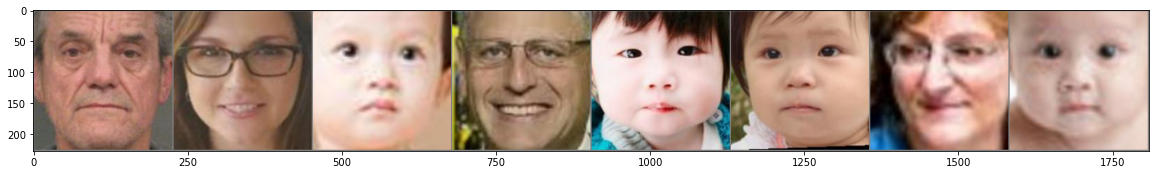

           72.0            26.0             2.0            51.0             3.0             1.0            54.0             1.0


In [6]:
# display some images

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%15s' % str(labels[j].item()) for j in range(8)))

In [7]:
# vgg16 pretrained network 받아서 씀
class Net(nn.Module):
    def __init__(self, use_pretrained=True):
        super(Net, self).__init__()
        ##implement this
        # [3, 224, 224]
        self.vgg = models.vgg16(pretrained = use_pretrained).features #fc layer 3 는 빼고 가져옴
        self.fc1 = nn.Linear(512 *7*7, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1)
        
    def forward(self, x):
        ##implement this
        x = self.vgg(x)
        x = x.view(-1, 512*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
#implement criterion
criterion = nn.MSELoss()

model = Net()
summary(model, batch_size=-1, input_size=(3, 224, 224), device='cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
def train(epoch):
    model.train()
    total_loss = 0.
    for batch_idx, (data, target) in enumerate(trainloader):
        target = target.type(torch.float).view(-1,1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        total_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), total_loss/(batch_idx+1)))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        target = target.type(torch.float).view(-1,1)
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        

    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}'.format(
        test_loss, correct, len(testloader.dataset)))

In [12]:
for epoch in range(5):
    train(epoch)
    test()

Train Epoch: 0 [0/8802 (0%)]	Loss: 1720.007812
Train Epoch: 0 [80/8802 (1%)]	Loss: 1049.114893
Train Epoch: 0 [160/8802 (2%)]	Loss: 850.542721
Train Epoch: 0 [240/8802 (3%)]	Loss: 717.430343
Train Epoch: 0 [320/8802 (4%)]	Loss: 647.373010
Train Epoch: 0 [400/8802 (5%)]	Loss: 596.598251
Train Epoch: 0 [480/8802 (5%)]	Loss: 562.854535
Train Epoch: 0 [560/8802 (6%)]	Loss: 546.209202
Train Epoch: 0 [640/8802 (7%)]	Loss: 499.717831
Train Epoch: 0 [720/8802 (8%)]	Loss: 464.299996
Train Epoch: 0 [800/8802 (9%)]	Loss: 439.834995
Train Epoch: 0 [880/8802 (10%)]	Loss: 420.936149
Train Epoch: 0 [960/8802 (11%)]	Loss: 405.734445
Train Epoch: 0 [1040/8802 (12%)]	Loss: 388.777702
Train Epoch: 0 [1120/8802 (13%)]	Loss: 374.481523
Train Epoch: 0 [1200/8802 (14%)]	Loss: 363.620595
Train Epoch: 0 [1280/8802 (15%)]	Loss: 353.053503
Train Epoch: 0 [1360/8802 (15%)]	Loss: 342.148188
Train Epoch: 0 [1440/8802 (16%)]	Loss: 333.029985
Train Epoch: 0 [1520/8802 (17%)]	Loss: 321.116496
Train Epoch: 0 [1600/8802

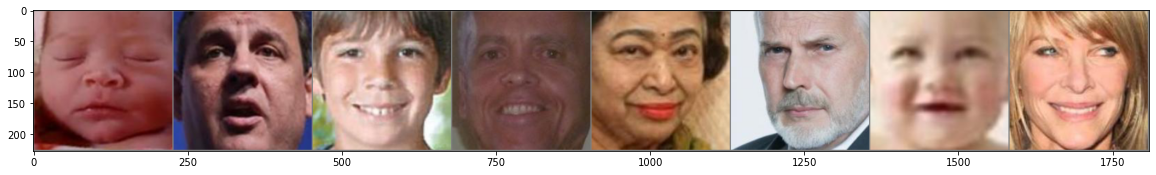

GrondTruth:    1.0  37.0  11.0  58.0  61.0  58.0   1.0  59.0


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#print images
imshow(torchvision.utils.make_grid(images))
print('GrondTruth: ', ' '.join('%5s' % labels[j].item() for j in range(8)))

In [18]:
images = images.to(device)
outputs = model(images)

outputs = outputs.squeeze()

print('Predicted: ', ' '.join('%.1f' % outputs[j].item() for j in range(8))) 

Predicted:  1.6 43.0 6.6 51.0 50.2 60.6 4.0 55.1
